## CrossEntropyLoss

In [18]:
def get_sent_embedding_and_label(dataloader, model, batch_size):
    """Get sentence embeddings array and labels array
    """
    sent_embeddings_arr = []
    labels_arr = []
    for i, batch in enumerate(dataloader):
        b_ids_tsr, b_masks_tsr, b_labels_tsr = tuple(tsrs for tsrs in batch)
        embeddings_tsr = model.extract_sent_embd(b_ids_tsr, b_masks_tsr)
        sent_embeddings_tsr = embeddings_tsr[:,0,:]
        sent_embeddings_arr.append(sent_embeddings_tsr)
        labels_arr.append(b_labels_tsr)
        if i == 7:
            print(f"the number of sample: {batch_size * (i+1)}")
            break
    sent_embeddings_arr = torch.cat(sent_embeddings_arr, dim=0).detach().cpu().numpy()
    labels_arr = torch.cat(labels_arr).detach().cpu().numpy()
    return sent_embeddings_arr, labels_arr

In [1]:
import argparse
import json
from copy import deepcopy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("ggplot")

from Utils.dataset import *
from Utils.utils import *
from Models.BertClf import *
from Models.LstmClf import *
from Models.ElectraClf import *

In [2]:
signature = "sw_ce_BERT_6M_1D_12H_36M"

In [3]:
parser = argparse.ArgumentParser()
#     opt = parser.parse_args() # in .py env
opt, _ = parser.parse_known_args() # in .ipynb env
with open('./Saved_models/' + signature + '_opt.txt', 'r') as f:
    opt.__dict__ = json.load(f)
print(opt)

Namespace(aug=0, author='sw_ce', batch_size=16, data_path='./Dataset', dropout=0.5, embedding_dim=256, eps=1e-08, freeze_pretrained=0, gpu=0, hidden_dim=768, kernel_depth=500, kernel_sizes=[3, 4, 5], lr_clf=0.0001, lr_pretrained=1e-05, max_epoch=30, max_len=50, model='BERT', num_layer=2, save=1, save_model_path='./Saved_models', save_submission_path='./Submissions', sent_embedding=0, signature='sw_ce_BERT_6M_1D_12H_36M', split_ratio=1, weight_decay=0.0005)


In [4]:
# Load the DataLoaders
train_dataloader, valid_dataloader, _ = data_load(opt)

Tokenizing data...
Apply the BertTokenizer...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


train_X_ids_tsr.shape: torch.Size([7805, 50])
train_X_masks_tsr.shape: torch.Size([7805, 50])
Tokenizing data...
Apply the BertTokenizer...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


valid_X_ids_tsr.shape: torch.Size([1748, 50])
valid_X_masks_tsr.shape: torch.Size([1748, 50])
Tokenizing data...
Apply the BertTokenizer...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


test_X_ids_tsr.shape: torch.Size([4311, 50])
test_X_masks_tsr.shape: torch.Size([4311, 50])
num of train_loader: 7805
num of valid_loader: 1748
num of test_loader: 4311


In [5]:
# Load untrained model
if opt.model == "BERT":
    model = BertClassifier(opt)
elif opt.model == "ELECTRA":
    model = ElectraClassifier(opt)
elif opt.model == "BILSTM":
    model = LstmClassifier(opt)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
def get_sent_embedding_and_label(dataloader, model, batch_size):
    """Get sentence embeddings array and labels array
    """
    sent_embeddings_arr = []
    labels_arr = []
    for i, batch in enumerate(dataloader):
        b_ids_tsr, b_masks_tsr, b_labels_tsr = tuple(tsrs for tsrs in batch)
        embeddings_tsr = model.extract_sent_embd(b_ids_tsr, b_masks_tsr)
        sent_embeddings_tsr = embeddings_tsr[:,0,:]
        sent_embeddings_arr.append(sent_embeddings_tsr)
        labels_arr.append(b_labels_tsr)
        if i == 7:
            print(f"the number of sample: {batch_size * (i+1)}")
            break
    sent_embeddings_arr = torch.cat(sent_embeddings_arr, dim=0).detach().cpu().numpy()
    labels_arr = torch.cat(labels_arr).detach().cpu().numpy()
    return sent_embeddings_arr, labels_arr

the number of sample: 128


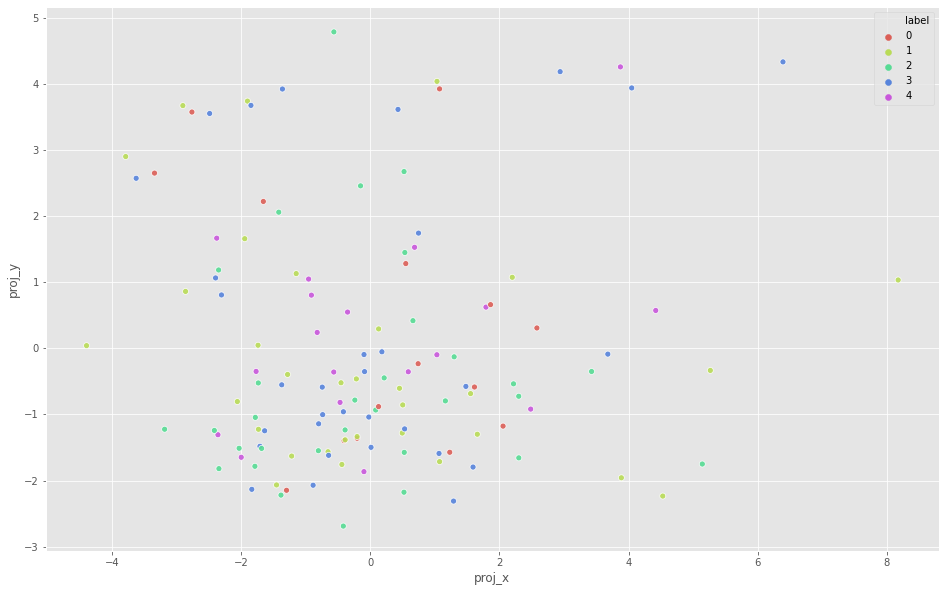

In [7]:
sent_embeddings_arr, labels_arr = get_sent_embedding_and_label(train_dataloader, model, opt.batch_size)
draw_embeddings(sent_embeddings_arr, labels_arr, option="pca")

the number of sample: 128


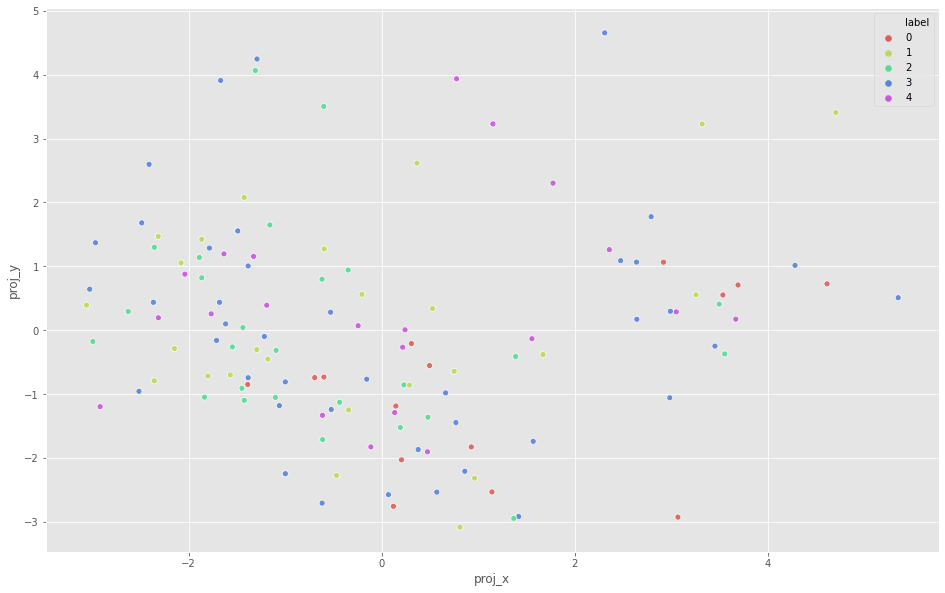

In [8]:
sent_embeddings_arr, labels_arr = get_sent_embedding_and_label(valid_dataloader, model, opt.batch_size)
draw_embeddings(sent_embeddings_arr, labels_arr, option="pca")

In [9]:
# Load trained model
model.to(torch.device("cpu"))
model_save_path = str(opt.save_model_path) + "/" + opt.signature +'.model'
model.load_state_dict(torch.load(model_save_path))
model

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

the number of sample: 128


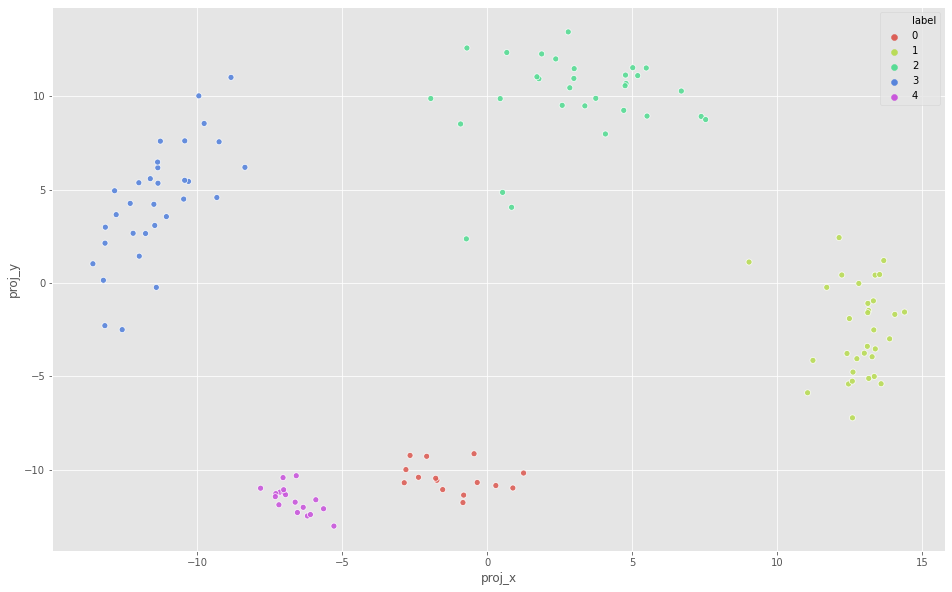

In [10]:
sent_embeddings_arr, labels_arr = get_sent_embedding_and_label(train_dataloader, model, opt.batch_size)
draw_embeddings(sent_embeddings_arr, labels_arr, option="pca")

the number of sample: 128


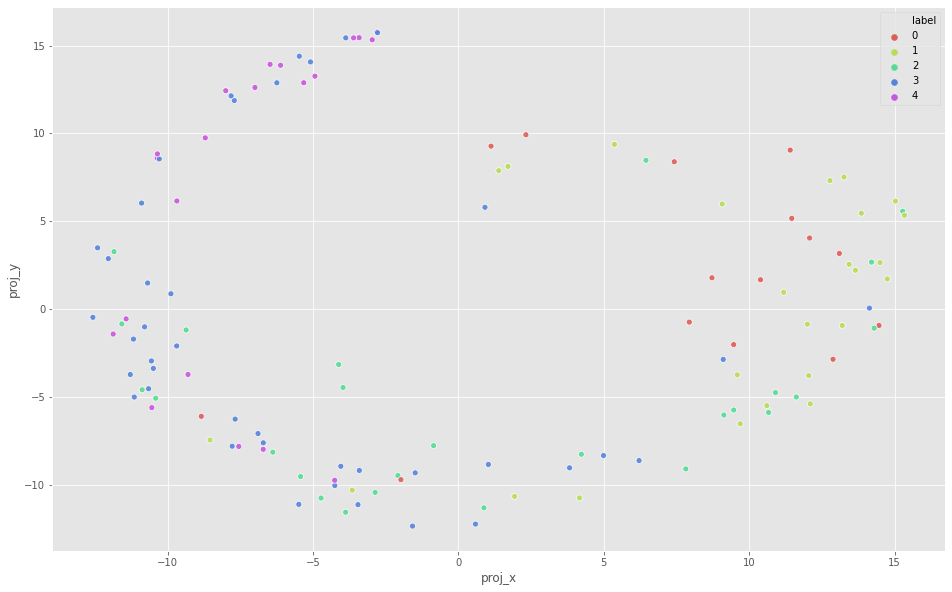

In [11]:
sent_embeddings_arr, labels_arr = get_sent_embedding_and_label(valid_dataloader, model, opt.batch_size)
draw_embeddings(sent_embeddings_arr, labels_arr, option="pca")

In [12]:
# Load trained model
model_save_path = str(opt.save_model_path) + "/" + opt.signature +'_full.model'
model.load_state_dict(torch.load(model_save_path))
model

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

the number of sample: 128


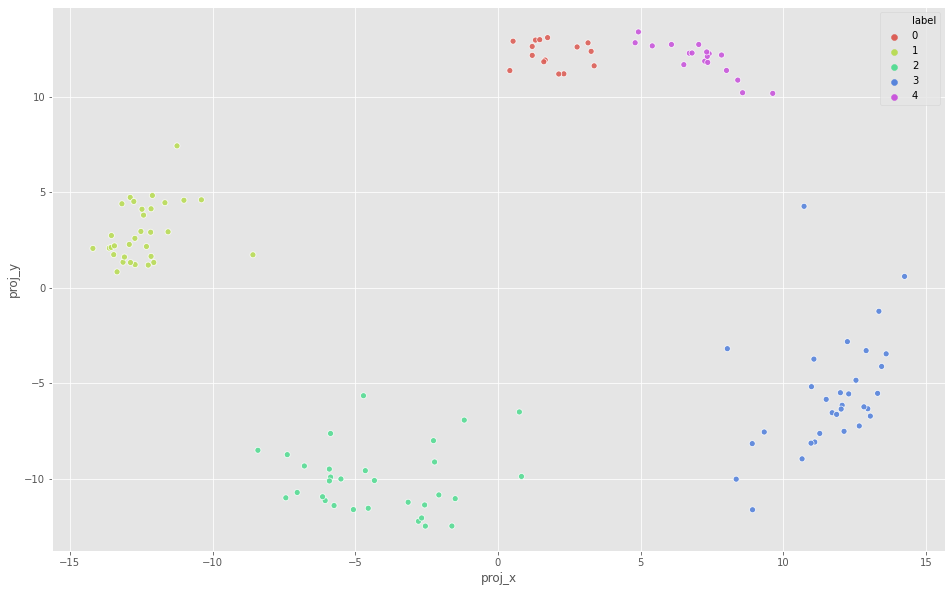

In [13]:
sent_embeddings_arr, labels_arr = get_sent_embedding_and_label(train_dataloader, model, opt.batch_size)
draw_embeddings(sent_embeddings_arr, labels_arr, option="pca")

the number of sample: 128


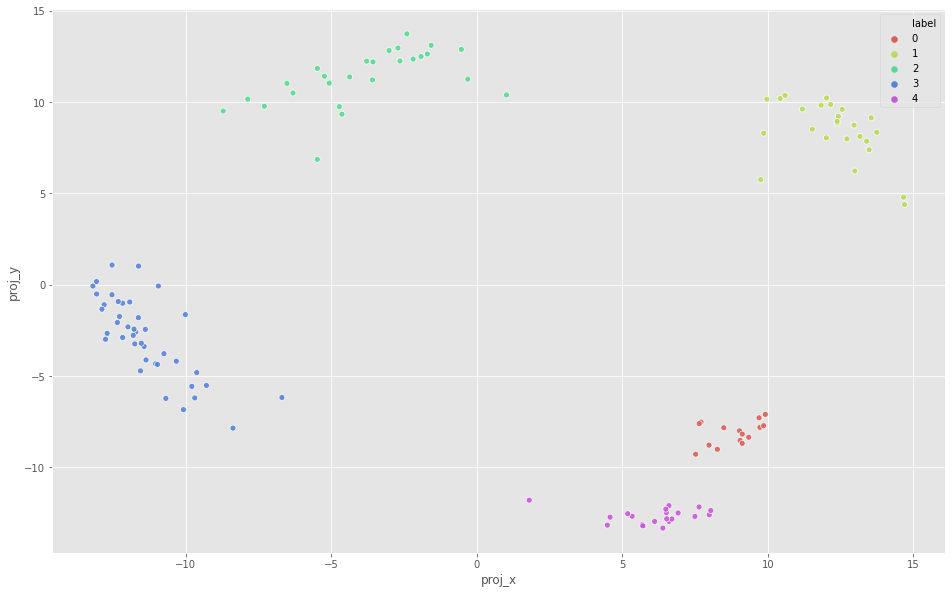

In [14]:
sent_embeddings_arr, labels_arr = get_sent_embedding_and_label(valid_dataloader, model, opt.batch_size)
draw_embeddings(sent_embeddings_arr, labels_arr, option="pca")